In [1]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from models.esdc_sampling import SamplingModel
from models.derivatives import GPRBFDerivative
from py_esdc.data import window_xy, get_xy_indices, get_3dgrid
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Experiment Variables

In [10]:
# variables for the experiment
variables = [
    'gross_primary_productivity',
    'land_surface_temperature',
#     'water_mask',
#     'country_mask'
]

window_size = 5
start_time = '2010-06'
end_time = '2010-06'
subsection = 'europe'
data_path = '/media/disk/databases/BACI-CABLAB/low_res_data/'
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'

# Initialize data class

esdc_data = ESDCData(
    variables=variables,
    time_frame=[start_time, end_time],
    subsection=subsection,
    minicube_path=minicube_path
)


## Get MiniCubes

In [11]:
%%time

save_name = f'nbexp_{window_size}.h5'

# Save Minicubes
dat = esdc_data.load_minicubes(save_name=save_name)

CPU times: user 1.03 s, sys: 780 ms, total: 1.81 s
Wall time: 1.85 s


In [12]:
time_stamps = [keys for keys in dat['gross_primary_productivity'].keys()]

In [13]:
print(time_stamps)

['2010-01-05T00:00:00.000000000', '2010-01-13T00:00:00.000000000', '2010-01-21T00:00:00.000000000', '2010-01-29T00:00:00.000000000', '2010-02-06T00:00:00.000000000', '2010-02-14T00:00:00.000000000', '2010-02-22T00:00:00.000000000', '2010-03-02T00:00:00.000000000', '2010-03-10T00:00:00.000000000', '2010-03-18T00:00:00.000000000', '2010-03-26T00:00:00.000000000', '2010-04-03T00:00:00.000000000', '2010-04-11T00:00:00.000000000', '2010-04-19T00:00:00.000000000', '2010-04-27T00:00:00.000000000', '2010-05-05T00:00:00.000000000', '2010-05-13T00:00:00.000000000', '2010-05-21T00:00:00.000000000', '2010-05-29T00:00:00.000000000', '2010-06-06T00:00:00.000000000', '2010-06-14T00:00:00.000000000', '2010-06-22T00:00:00.000000000', '2010-06-30T00:00:00.000000000', '2010-07-08T00:00:00.000000000', '2010-07-16T00:00:00.000000000', '2010-07-24T00:00:00.000000000', '2010-08-01T00:00:00.000000000', '2010-08-09T00:00:00.000000000', '2010-08-17T00:00:00.000000000', '2010-08-25T00:00:00.000000000', '2010-09-

### Training & Testing

In [22]:
x = dat[variables[1]][time_stamps[0]]['x']
y = dat[variables[1]][time_stamps[0]]['y']
lat = dat[variables[1]][time_stamps[0]]['lat']
lon = dat[variables[1]][time_stamps[0]]['lon']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=2000, random_state=123)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Train GP Model

In [48]:
%%time
sampling_model = SamplingModel()

sampling_model.train_model(xtrain, ytrain)

CPU times: user 6min 32s, sys: 5.4 s, total: 6min 38s
Wall time: 25 s


In [49]:
%%time
# Testing
ypred = sampling_model.test_model(xtest)

CPU times: user 3.04 s, sys: 184 ms, total: 3.22 s
Wall time: 377 ms


In [50]:
%%time 

# sensitivity
sens_type = 'dim'
sens_summary = 'abs'

sens_dim = sampling_model.sensitivity(
    xtest,
    sens=sens_type,
    method=sens_summary
)

CPU times: user 29 s, sys: 196 ms, total: 29.2 s
Wall time: 1.99 s


In [47]:
print(xtest.shape)

(11656, 24)


## Train/Test Statistics

In [58]:
results = sampling_model.get_statistics(xtest, ytest)


In [59]:
print('MAE: {:.4f}'.format(results['mae']))
print('MSE: {:.4f}'.format(results['mse']))
print('R2: {:.4f}'.format(results['r2']))
print('RMSE: {:.4f}'.format(results['rmse']))
print('Sens: {:.4f}'.format(results['sens']))

MAE: 0.9187
MSE: 1.7692
R2: 0.9842
RMSE: 1.3301
Sens: 0.0021


## Save Model

In [22]:
# save_name = 'experiment_5.pckl'
# print(sampling_model.model)
# sampling_model.save_model(save_name)

## Load Model

In [23]:
# sampling_model.model = None
# sampling_model.model

In [24]:
# sampling_model.load_model(save_name)
# sampling_model.model

## Get Plot Data

In [78]:
sens_plot = sampling_model.sensitivity(x, sens='point')
ypred = sampling_model.test_model(x)


#### Convert to XArray

In [7]:
def get_original_coordinates(variable, start_time, end_time, subsection):
    
    # Extract original cube
    esdc_data = ESDCData(
        variables=[variable],
        time_frame=[start_time, end_time],
        subsection=subsection
    )
    
    # extract plot data
    plot_data = esdc_data.extract_datacube()
    
    # Get original coordinates
    xr_lon = plot_data.lon.values
    xr_lat = plot_data.lat.values
    
    return xr_lon, xr_lat

In [8]:
def create_xarray(labels, pred, sens, lat, lon, variable, time_stamp, subsection, window_size):
    
    # Get original coordinates
    xr_lon, xr_lat = get_original_coordinates(variable, time_stamp, time_stamp, subsection)
    
    # create raster data
    pred = get_3dgrid(pred, lat, lon, xr_lat, xr_lon)
    sens = get_3dgrid(sens, lat, lon, xr_lat, xr_lon)
    labels = get_3dgrid(labels, lat, lon, xr_lat, xr_lon)
    
    # Create Xarray
    xr_results = xr.Dataset(
        data_vars={
            'labels': (['lat', 'lon', 'time', 'window'], labels[..., None, None]),
             'sensitivity': (['lat', 'lon', 'time', 'window'], sens[..., None, None]),
             'predictions': (['lat', 'lon', 'time', 'window'], pred[..., None, None])},
         coords={
             'lon': xr_lon,
             'lat': xr_lat,
             'time': pd.date_range(time_stamps[0], periods=1),
             'window': [window_size]},
    )
    
    # Add Mask
    # Extract original cube
    esdc_data = ESDCData(
        variables=['water_mask'],
        time_frame=['2001', '2001'],
        subsection=subsection
    )

    # Water Mask
    mask_data = esdc_data.extract_datacube().isel(time=0).water_mask

    # Add Mask
    xr_results.coords['mask'] = (('lat', 'lon'), mask_data)

    return xr_results

In [108]:
xr_results = create_xarray(y, ypred, sens_plot, lat, lon, 
                           variables[1], time_stamps[0], subsection, window_size)

xr_results

<xarray.Dataset>
Dimensions:      (lat: 144, lon: 312, time: 1, window: 1)
Coordinates:
  * lon          (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat          (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
  * time         (time) datetime64[ns] 2010-06-06
  * window       (window) int64 5
    mask         (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0
Data variables:
    labels       (lat, lon, time, window) float64 nan nan nan ... nan nan nan
    sensitivity  (lat, lon, time, window) float64 nan nan nan ... nan nan nan
    predictions  (lat, lon, time, window) float64 nan nan nan ... nan nan nan

In [80]:
# ===========================
# Convert to XArray
# ===========================

xr_lon, xr_lat = get_original_coordinates(variables[1], time_stamps[0], time_stamps[0], subsection)

# Create Raster Data
predictions = get_3dgrid(ypred, lat, lon, xr_lat, xr_lon)
sensitivitiy = get_3dgrid(sens_plot, lat, lon, xr_lat, xr_lon)
labels = get_3dgrid(y, lat, lon, xr_lat, xr_lon)

In [82]:
xr_results = xr.Dataset(
    data_vars={
        'labels': (['lat', 'lon', 'time', 'window'], labels[..., None, None]),
         'sensitivity': (['lat', 'lon', 'time', 'window'], sensitivitiy[..., None, None]),
         'predictions': (['lat', 'lon', 'time', 'window'], predictions[..., None, None])},
     coords={
         'lon': xr_lon,
         'lat': xr_lat,
         'time': pd.date_range(time_stamps[0], periods=1),
         'window': [window_size]},
    attrs={
        'rmse': rmse,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'variable': variable
    }
)

# Add attributes to data
xr_results

<xarray.Dataset>
Dimensions:      (lat: 144, lon: 312, time: 1, window: 1)
Coordinates:
  * lon          (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat          (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
  * time         (time) datetime64[ns] 2010-01-05
  * window       (window) int64 5
Data variables:
    labels       (lat, lon, time, window) float64 nan nan nan ... nan nan nan
    sensitivity  (lat, lon, time, window) float64 nan nan nan ... nan nan nan
    predictions  (lat, lon, time, window) float64 nan nan nan ... nan nan nan
Attributes:
    rmse:      1.3301572792572292
    mae:       0.9187530847174021
    mse:       1.7693183875609941
    r2:        0.9847204817637984
    variable:  gross_primary_productivity

In [36]:
# # select data subset
# subset = xr_results.predictions.isel(window=0).isel(time=0)

# print(subset)
# fig = plt.figure(figsize=(10, 6))

# ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')


# p = subset.plot.pcolormesh(
#     ax=ax, transform=ccrs.PlateCarree(),
#     robust=True, cmap='viridis', vmin=0,
# #         cbar_kwargs={'label': subset.gross_primary_productivity.units, 
# #                      'format': '%.1f'}
# )
# # cbar = fig.colorbar(p)
# ax.coastlines(linewidth=2)
# ax.gridlines(draw_labels=True)
# ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor', fontsize=20,
#         transform=ax.transAxes)
# ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
#         rotation='horizontal', rotation_mode='anchor', fontsize=20,
#         transform=ax.transAxes)
# plt.tight_layout()
# # save_plt_name = f'{variable}_labels_mean_before_{window_size}'
# # plt.savefig(figures_path + save_plt_name + '.png')
# plt.show()

#### Masks

In [83]:
# Extract original cube
esdc_data = ESDCData(
    variables=['water_mask'],
    time_frame=['2001', '2001'],
    subsection='europe'
)

# Water Mask
mask_data = esdc_data.extract_datacube().isel(time=0).water_mask

# Add Mask
xr_results.coords['mask'] = (('lat', 'lon'), mask_data)

<xarray.DataArray (lat: 144, lon: 312)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat      (lat) float32 71.375 71.125 70.875 70.625 ... 36.125 35.875 35.625
    time     datetime64[ns] 2010-01-05
    window   int64 5
    mask     (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


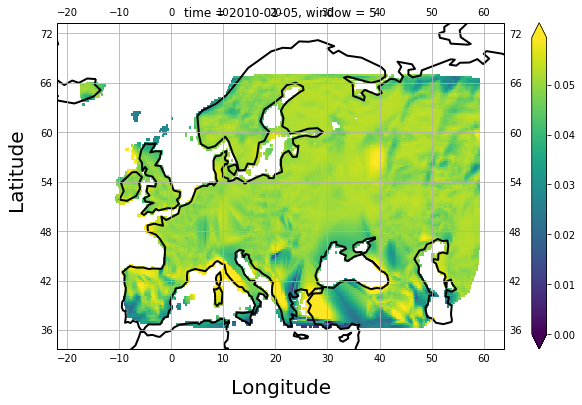

In [84]:

# select data subset
subset = xr_results.sensitivity.isel(window=0).isel(time=0).where(xr_results.mask == 1)

print(subset)
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')


p = subset.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    robust=True, cmap='viridis', vmin=0,
#         cbar_kwargs={'label': subset.gross_primary_productivity.units, 
#                      'format': '%.1f'}
)
# cbar = fig.colorbar(p)
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()
# save_plt_name = f'{variable}_labels_mean_before_{window_size}'
# plt.savefig(figures_path + save_plt_name + '.png')
plt.show()

### Save Results

In [41]:
save_path = '/home/emmanuel/projects/2019_sakame/data/results/'
save_name = f"experiment_{variable}.nc"
xr_results.to_netcdf(save_path + save_name)

### Load Results

In [42]:
with xr.open_dataset(save_path + save_name) as xr_results:
    print(xr_results)

<xarray.Dataset>
Dimensions:      (lat: 144, lon: 312, time: 1, window: 1)
Coordinates:
  * lon          (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat          (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
  * time         (time) datetime64[ns] 2010-01-05
  * window       (window) int64 5
    mask         (lat, lon) float32 ...
Data variables:
    labels       (lat, lon, time, window) float64 ...
    sensitivity  (lat, lon, time, window) float64 ...
    predictions  (lat, lon, time, window) float64 ...
Attributes:
    rmse:      1.3301572792572292
    mae:       0.9187530847174021
    mse:       1.7693183875609941
    r2:        0.9847204817637984
    variable:  gross_primary_productivity


## Experiment

In [110]:
%%time

# Experimental Parameters
window_sizes = [2, 3, 4, 5, 6, 7, 8, 9 , 10]
variables = [
#     'land_surface_temperature',
    'gross_primary_productivity',
    'air_temperature_2m',
#     'precipitation',
#     'evaporation',
#     'soil_moisture',
#     'surface_moisture',

]
save_path = '/home/emmanuel/projects/2019_sakame/data/results/sampling/'
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'
start_time = '2010-06'
end_time = '2010-06'
summer_times =[
    '2010-06-06T00:00:00.000000000', 
    '2010-06-14T00:00:00.000000000', 
    '2010-06-22T00:00:00.000000000', 
    '2010-06-30T00:00:00.000000000', 
    '2010-07-08T00:00:00.000000000', 
    '2010-07-16T00:00:00.000000000', 
    '2010-07-24T00:00:00.000000000', 
    '2010-08-01T00:00:00.000000000', 
    '2010-08-09T00:00:00.000000000', 
    '2010-08-17T00:00:00.000000000', 
    '2010-08-25T00:00:00.000000000'
]
train_size = 5000
random_state = 123
subsection = 'europe'
np.random.seed(123)


for ivariable in variables:
    print(f"Variable: {ivariable}")
    
    window_arrays = list()
    results_df = pd.DataFrame()
    for iwindow in window_sizes:
        print(f"Window: {iwindow}")

        # Initialize data class

        esdc_data = ESDCData(
            minicube_path=minicube_path,
            variables=[str(ivariable)],
            time_frame=[start_time, end_time],
            subsection=subsection,
        
        )
        
        # load minicubes
        save_name = f'nbexp_{iwindow}.h5'
        dat = esdc_data.load_minicubes(save_name=save_name)
        
        # Get Time Stamps
        time_stamps = [keys for keys in dat[ivariable].keys()]
        
        itrain_size = np.int(train_size / len(time_stamps))
                
        time_arrays = list()
        xtrain, ytrain = list(), list()
        
        # generate a random sequence for each time stamp
        rand_nums = np.random.randint(low=0, high=100, size=len(time_stamps))
        
        # Loop through time stamps
        for iteration, itime in enumerate(summer_times):
            
            
            # Extract Data
            x = dat[ivariable][itime]['x']
            y = dat[ivariable][itime]['y']
            
            ixtrain, _, iytrain, _ = train_test_split(
                x, y, train_size=itrain_size, random_state=rand_nums[iteration]
            )
            xtrain.append(ixtrain)
            ytrain.append(iytrain)
            
        xtrain = np.vstack((xtrain))
        ytrain = np.hstack(ytrain)

        # Train GP Model over period
        sampling_model = SamplingModel()

        sampling_model.train_model(xtrain, ytrain)
            
        for itime in summer_times:
            print(f"Time Stamp: {itime[:10]}")
            # Extract Data
            x = dat[ivariable][itime]['x']
            y = dat[ivariable][itime]['y']
            lat = dat[ivariable][itime]['lat']
            lon = dat[ivariable][itime]['lon']
            
            # Test Statistics
            results = sampling_model.get_statistics(x, y)
            
            # Append stats to big dataframe
            results_df = results_df.append({
                'variable': ivariable,
                'time': itime,
                'window': iwindow,
                'mae': results['mae'],
                'mse': results['mse'],
                'rmse': results['rmse'],
                'r2': results['r2'],
                'sens': results['sens']
            }, ignore_index=True)
            
            # Get Plot Data
            sens_plot = sampling_model.sensitivity(x, sens='point')
            ypred = sampling_model.test_model(x)
            xr_lon, xr_lat = get_original_coordinates(ivariable, itime, itime, subsection)
            
            # append created xarray
            time_arrays.append(create_xarray(
                y, ypred, sens_plot, lat, lon,
                ivariable, itime, subsection, iwindow
            ))
            
        # merge time_arrays
        window_arrays.append(xr.concat(time_arrays, dim='time'))
        
    window_arrays = xr.concat(window_arrays, dim='window')
    
    window_arrays.to_netcdf(save_path + f'sampling_{ivariable}.nc')
    results_df.to_csv(save_path + f'sampling_{ivariable}.csv')

Variable: gross_primary_productivity
Window: 2


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 3


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 4


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 5


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 6


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00020076, -0.00015749]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 7


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 8


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 9


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 10


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Variable: air_temperature_2m
Window: 2


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 3


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 4


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.04838109,  1.68553121]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 5


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 6


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 7


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 8


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 9


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
Window: 10


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time Stamp: 2010-06-06
Time Stamp: 2010-06-14
Time Stamp: 2010-06-22
Time Stamp: 2010-06-30
Time Stamp: 2010-07-08
Time Stamp: 2010-07-16
Time Stamp: 2010-07-24
Time Stamp: 2010-08-01
Time Stamp: 2010-08-09
Time Stamp: 2010-08-17
Time Stamp: 2010-08-25
CPU times: user 12h 37min 7s, sys: 42.3 s, total: 12h 37min 50s
Wall time: 1h 43s


In [104]:
print(window_arrays)

<xarray.Dataset>
Dimensions:      (lat: 144, lon: 312, time: 4, window: 6)
Coordinates:
  * lon          (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat          (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
    mask         (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0
  * time         (time) datetime64[ns] 2010-01-05 2010-01-05 ... 2010-01-05
  * window       (window) int64 2 3 4 5 6 7
Data variables:
    labels       (lat, lon, time, window) float64 nan nan nan ... nan nan nan
    sensitivity  (lat, lon, time, window) float64 nan nan nan ... nan nan nan
    predictions  (lat, lon, time, window) float64 nan nan nan ... nan nan nan
